Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ADF Test Statistic: -2.8722540598208903
p-value: 0.04867091607988635


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


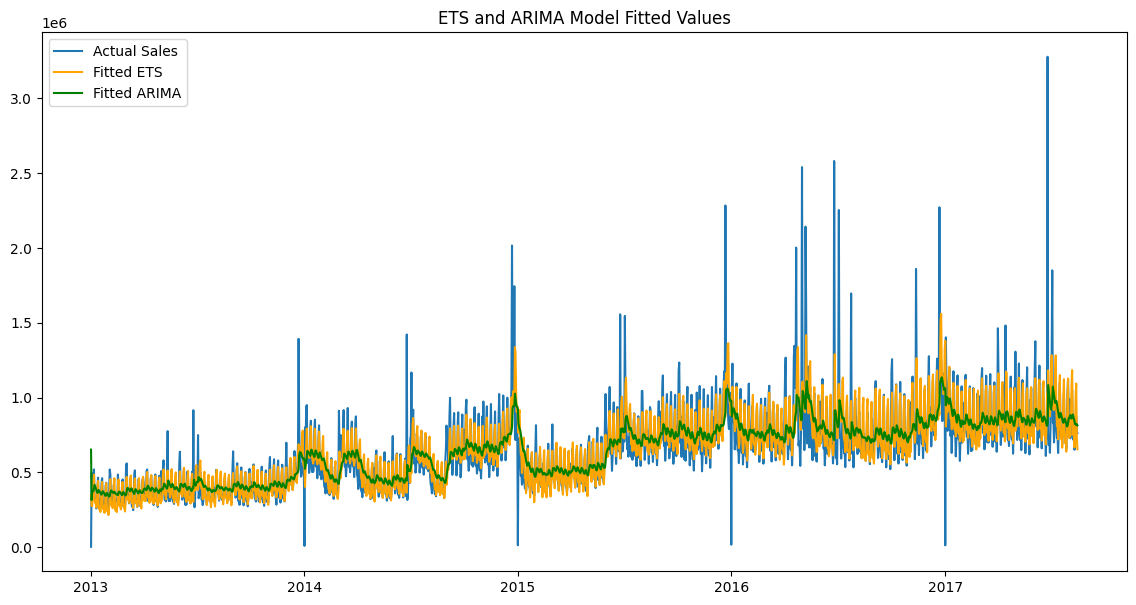

Submission files are saved: ETS and ARIMA forecasts.


In [32]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Load datasets
train_data = pd.read_csv ('/content/drive/MyDrive/store-sales-time-series-forecasting/train.csv')
transactions = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/transactions.csv')
holidays_events = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/oil.csv')
stores = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/stores.csv')
test_data = pd.read_csv('/content/drive/MyDrive/store-sales-time-series-forecasting/test.csv')

# Convert date columns to datetime format
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

# Merge datasets
train_merged = train_data.merge(stores, on='store_nbr', how='left')
test_merged = test_data.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(transactions, on=['date', 'store_nbr'], how='left')
test_merged = test_merged.merge(transactions, on=['date', 'store_nbr'], how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
test_merged = test_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(holidays_events, on='date', how='left')
test_merged = test_merged.merge(holidays_events, on='date', how='left')

# Define holiday flag
train_merged['is_holiday'] = train_merged['type_y'].notnull().astype(int)
test_merged['is_holiday'] = test_merged['type_y'].notnull().astype(int)

# Fill missing values using ffill and bfill
train_merged['dcoilwtico'] = train_merged['dcoilwtico'].ffill().bfill()
test_merged['dcoilwtico'] = test_merged['dcoilwtico'].ffill().bfill()
train_merged['transactions'] = train_merged['transactions'].fillna(0)
test_merged['transactions'] = test_merged['transactions'].fillna(0)

# Aggregate sales for time series modeling
sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()
sales_trend.set_index('date', inplace=True)

# Create a complete date range
full_date_range = pd.date_range(start=sales_trend.index.min(), end=sales_trend.index.max(), freq='D')

# Reindex sales_trend to the full date range
sales_trend = sales_trend.reindex(full_date_range)

# Fill missing values with forward-fill and backward-fill
sales_trend['sales'] = sales_trend['sales'].ffill().bfill()

# Set the new index with frequency
sales_trend.index.freq = 'D'

# Check stationarity using ADF test
adf_result = adfuller(sales_trend['sales'])
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Fit ETS model
ets_model = ExponentialSmoothing(
    sales_trend['sales'],
    seasonal='add',
    seasonal_periods=7,  # Weekly seasonality
    trend='add',
    initialization_method='estimated'
).fit()

# Forecast using ETS model
ets_forecast = ets_model.forecast(len(test_merged['date'].unique()))

# Fit ARIMA model
arima_model = ARIMA(sales_trend['sales'], order=(1, 0, 1)).fit()

# Forecast using ARIMA model
arima_forecast = arima_model.forecast(len(test_merged['date'].unique()))

# Prepare submission files
ets_submission = test_merged[['id']].copy()
arima_submission = test_merged[['id']].copy()

# Align forecasts with test dataset structure
ets_forecast_replicated = pd.Series(ets_forecast.values).repeat(
    test_merged['date'].value_counts().sort_index().values
)[:len(test_merged)]
arima_forecast_replicated = pd.Series(arima_forecast.values).repeat(
    test_merged['date'].value_counts().sort_index().values
)[:len(test_merged)]

ets_submission['sales'] = ets_forecast_replicated.values
arima_submission['sales'] = arima_forecast_replicated.values

# Save submissions
ets_submission.to_csv('/content/drive/MyDrive/ets_submission.csv', index=False)
arima_submission.to_csv('/content/drive/MyDrive/arima_submission.csv', index=False)

# Plotting ETS and ARIMA fits
plt.figure(figsize=(14, 7))
plt.plot(sales_trend.index, sales_trend['sales'], label='Actual Sales')
plt.plot(ets_model.fittedvalues, label='Fitted ETS', color='orange')
plt.plot(arima_model.fittedvalues, label='Fitted ARIMA', color='green')
plt.title('ETS and ARIMA Model Fitted Values')
plt.legend()
plt.show()

print("Submission files are saved: ETS and ARIMA forecasts.")


In [33]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Load datasets from Google Drive
train_data = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/test.csv')

# Combine train and test datasets for consistent preprocessing
test_data['SalePrice'] = np.nan  # Use np.nan for missing values
combined_data = pd.concat([train_data, test_data], axis=0, ignore_index=True)

# Handle missing values
# Fill categorical columns with "None"
categorical_cols = combined_data.select_dtypes(include='object').columns
combined_data[categorical_cols] = combined_data[categorical_cols].fillna("None")

# Fill numerical columns with median values (excluding SalePrice)
numerical_cols = combined_data.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop('SalePrice')  # Exclude SalePrice
for col in numerical_cols:
    combined_data[col] = combined_data[col].fillna(combined_data[col].median())

# Separate target variable before one-hot encoding
y = combined_data['SalePrice']
combined_data = combined_data.drop(columns=['SalePrice'])

# One-hot encode categorical variables
combined_data_encoded = pd.get_dummies(combined_data, drop_first=True)

# Standardize numerical features (excluding SalePrice)
scaler = StandardScaler()
combined_data_encoded[numerical_cols] = scaler.fit_transform(combined_data_encoded[numerical_cols])

# Split the data back into train and test sets
X_train = combined_data_encoded[y.notna()].copy()  # Create explicit copies
X_test = combined_data_encoded[y.isna()].copy()
y_train = y[y.notna()]

# Log-transform SalePrice to handle skewness
y_train = np.log1p(y_train)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Feature Engineering: Polynomial Features for top predictors
top_predictors = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train[top_predictors])
X_val_poly = poly.transform(X_val[top_predictors])

# Merge polynomial features back into the datasets
poly_feature_names = poly.get_feature_names_out(top_predictors)
X_train_expanded = X_train.copy()
X_val_expanded = X_val.copy()
X_train_expanded[poly_feature_names] = X_train_poly
X_val_expanded[poly_feature_names] = X_val_poly

# Align test set with training set features (add missing columns, fill with 0)
missing_cols = set(X_train_expanded.columns) - set(X_test.columns)
for col in missing_cols:
    X_test.loc[:, col] = 0  # Use .loc[] for safer assignment
X_test = X_test[X_train_expanded.columns]  # Ensure same column order

# Handle remaining missing values in training and validation sets
columns_to_impute = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
for col in columns_to_impute:
    X_train_expanded[col] = X_train_expanded[col].fillna(X_train_expanded[col].median())
    X_val_expanded[col] = X_val_expanded[col].fillna(X_train_expanded[col].median())

# Train models
# Model 1: Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_expanded, y_train)
y_pred_linear = linear_model.predict(X_val_expanded)
rmse_linear = np.sqrt(mean_squared_error(y_val, y_pred_linear))

# Model 2: Ridge Regression (with increased alpha)
ridge_model = Ridge(alpha=10.0, random_state=42)
ridge_model.fit(X_train_expanded, y_train)
y_pred_ridge = ridge_model.predict(X_val_expanded)
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge))

# Model 3: Lasso Regression (with increased max_iter)
lasso_model = Lasso(alpha=0.01, max_iter=10000, random_state=42)
lasso_model.fit(X_train_expanded, y_train)
y_pred_lasso = lasso_model.predict(X_val_expanded)
rmse_lasso = np.sqrt(mean_squared_error(y_val, y_pred_lasso))

# Test set processing (add polynomial features)
test_poly = poly.transform(X_test[top_predictors])
X_test[poly_feature_names] = test_poly

# Handle missing values in the test set
columns_to_impute_test = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                          'BsmtFullBath', 'BsmtHalfBath', 'GarageArea']
for col in columns_to_impute_test:
    X_test[col] = X_test[col].fillna(X_train_expanded[col].median())

# Generate predictions on the test dataset
test_predictions_linear = linear_model.predict(X_test)
test_predictions_ridge = ridge_model.predict(X_test)
test_predictions_lasso = lasso_model.predict(X_test)

# Reverse the log transformation
test_predictions_linear = np.expm1(test_predictions_linear)
test_predictions_ridge = np.expm1(test_predictions_ridge)
test_predictions_lasso = np.expm1(test_predictions_lasso)

# Print test predictions
print("Test Predictions (Linear Regression):\n", test_predictions_linear)
print("Test Predictions (Ridge Regression):\n", test_predictions_ridge)
print("Test Predictions (Lasso Regression):\n", test_predictions_lasso)

# Create submission files
submission_linear = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_predictions_linear
})
submission_ridge = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_predictions_ridge
})
submission_lasso = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': test_predictions_lasso
})

# Save each submission file to Google Drive
submission_linear.to_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/kaggle_submission_linear.csv', index=False)
submission_ridge.to_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/kaggle_submission_ridge.csv', index=False)
submission_lasso.to_csv('/content/drive/MyDrive/house-prices-advanced-regression-techniques/kaggle_submission_lasso.csv', index=False)

print("Files saved as kaggle_submission_linear.csv, kaggle_submission_ridge.csv, and kaggle_submission_lasso.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test Predictions (Linear Regression):
 [118415.04299802 166792.58880357 185987.78262446 ... 172476.77637699
 120633.95071778 216098.78056927]
Test Predictions (Ridge Regression):
 [112134.00313863 157644.02759908 181061.27359464 ... 171619.27984286
 116299.44602697 224607.77786056]
Test Predictions (Lasso Regression):
 [119273.25194087 152994.63143778 175680.37407779 ... 175768.29815777
 115612.47358209 234548.76598812]
Files saved as kaggle_submission_linear.csv, kaggle_submission_ridge.csv, and kaggle_submission_lasso.csv


In [34]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer

# Load the original train dataset from Google Drive
train = pd.read_csv('/content/drive/MyDrive/sfcrime/traincsv/train.csv')

# Taking a random sample from the train dataset (e.g., 10% of the data)
sampled_train = train.sample(frac=0.1, random_state=42)

# Saving the sampled data to a new CSV file
sampled_file_path = '/content/drive/MyDrive/sfcrime/sampled_train.csv'
sampled_train.to_csv(sampled_file_path, index=False)

# Load the datasets
train_path = '/content/drive/MyDrive/sfcrime/sampled_train.csv'
test_path = '/content/drive/MyDrive/sfcrime/testcsv/test.csv'

train = pd.read_csv(train_path, parse_dates=['Dates'])
test = pd.read_csv(test_path, parse_dates=['Dates'])

# Display any missing values in the datasets
print("Missing values in training data:")
print(train.isnull().sum())
print("\nMissing values in test data:")
print(test.isnull().sum())

# Function to extract datetime features
def extract_datetime_features(df):
    df['Year'] = df['Dates'].dt.year
    df['Month'] = df['Dates'].dt.month
    df['Day'] = df['Dates'].dt.day
    df['Hour'] = df['Dates'].dt.hour
    df['Minute'] = df['Dates'].dt.minute
    df['DayOfWeekNum'] = df['Dates'].dt.dayofweek  # Monday=0, Sunday=6
    df['IsWeekend'] = df['DayOfWeekNum'].apply(lambda x: 1 if x >= 5 else 0)
    return df

# Apply the function to both datasets
train = extract_datetime_features(train)
test = extract_datetime_features(test)

# Label encode the target variable 'Category'
le_category = LabelEncoder()
train['CategoryEncoded'] = le_category.fit_transform(train['Category'])

# Combine train and test datasets for consistent encoding
train['IsTrain'] = 1
test['IsTrain'] = 0
combined = pd.concat([train, test], axis=0, sort=False)

# One-hot encode 'PdDistrict' and 'DayOfWeek'
combined = pd.get_dummies(combined, columns=['PdDistrict', 'DayOfWeek'], drop_first=True)

# Drop unnecessary columns
combined = combined.drop(['Dates', 'Descript', 'Resolution', 'Address', 'Category'], axis=1)

# Separate back the train and test sets
train = combined[combined['IsTrain'] == 1].copy()
test = combined[combined['IsTrain'] == 0].copy()

# Drop helper column 'IsTrain'
train = train.drop(['IsTrain'], axis=1)
test = test.drop(['IsTrain'], axis=1)

# Ensure consistent features between train and test sets
test_ids = test['Id'].copy()
train = train.drop(['Id'], axis=1)
X_train = train.drop(['CategoryEncoded'], axis=1)
y_train = train['CategoryEncoded']
X_test = test[X_train.columns]

# List of numerical features
numerical_features = ['X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'Minute']

# Correct erroneous coordinates in 'X' and 'Y' if necessary
X_train['X'] = X_train['X'].apply(lambda x: -122.4194 if x > -121 else x)
X_train['Y'] = X_train['Y'].apply(lambda y: 37.7749 if y > 38 else y)
X_test['X'] = X_test['X'].apply(lambda x: -122.4194 if x > -121 else x)
X_test['Y'] = X_test['Y'].apply(lambda y: 37.7749 if y > 38 else y)

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Check for and handle NaNs and infinities in X_train
nan_columns = X_train.columns[X_train.isna().any()].tolist()
inf_columns = X_train.columns[X_train.isin([np.inf, -np.inf]).any()].tolist()

if nan_columns:
    print("Columns with NaNs:", nan_columns)
    if nan_columns:
        imputer = SimpleImputer(strategy='mean')
        X_train[nan_columns] = imputer.fit_transform(X_train[nan_columns])

if inf_columns:
    print("Columns with infinities:", inf_columns)
    X_train[inf_columns] = np.clip(X_train[inf_columns], a_min=-1e6, a_max=1e6)

# Ensure there are no missing values after scaling and handling NaNs/infinities
print("Missing values in X_train after scaling and NaN/infinity handling:")
print(X_train.isnull().sum().sum())  # Should print 0

# Handle class imbalance or minor classes
class_counts = y_train.value_counts()
minor_classes = class_counts[class_counts < 2].index

# Optionally remove minor classes (if applicable)
X_train = X_train[~y_train.isin(minor_classes)]
y_train = y_train[~y_train.isin(minor_classes)]

# Sample a subset of the data
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=50000, stratify=y_train, random_state=42)

# Impute any remaining NaNs in X_sample
imputer = SimpleImputer(strategy='mean')
X_sample = imputer.fit_transform(X_sample)

# Model 1: Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Cross-validation for Decision Tree
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_cv_scores = cross_val_score(dt_model, X_train, y_train, cv=skf, scoring='neg_log_loss', n_jobs=-1)
print(f'Decision Tree Cross-Validation Log Loss: {-dt_cv_scores.mean():.4f}')

# Model 2: Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=skf, scoring='neg_log_loss', n_jobs=-1)
print(f'Random Forest Cross-Validation Log Loss: {-rf_cv_scores.mean():.4f}')

# Model 3: Support Vector Machine using SGDClassifier for multiclass classification
# SVM Model
svm_model = SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42)
svm_model.fit(pd.DataFrame(X_sample, columns=X_train.columns), y_sample)  # Fit with DataFrame to retain feature names

# Cross-validation for SVM
svm_cv_scores = cross_val_score(svm_model, pd.DataFrame(X_sample, columns=X_train.columns), y_sample, cv=skf, scoring='accuracy', n_jobs=-1)
print(f'SVM Cross-Validation Accuracy: {svm_cv_scores.mean():.4f}')

# Ensure consistent class labels
num_classes = len(le_category.classes_)

# Predict probabilities for the test set
dt_probs = dt_model.predict_proba(X_test)

# Ensure the shape of the predicted probabilities matches the number of classes
if dt_probs.shape[1] != num_classes:
    missing_cols = set(le_category.classes_) - set(range(dt_probs.shape[1]))
    for col in missing_cols:
        dt_probs = np.hstack([dt_probs, np.zeros((dt_probs.shape[0], 1))])
    dt_probs = dt_probs[:, :num_classes]

# Create the submission DataFrame for Decision Tree
dt_submission = pd.DataFrame(dt_probs, columns=le_category.classes_)
dt_submission.insert(0, 'Id', test_ids.values.astype(int))
dt_submission.to_csv('/content/drive/MyDrive/decision_tree_submission.csv', index=False)
print("Decision Tree submission file created: decision_tree_submission.csv")

# Predict probabilities for Random Forest
rf_probs = rf_model.predict_proba(X_test)

# Ensure the shape of the predicted probabilities matches the number of classes
if rf_probs.shape[1] != num_classes:
    missing_cols = set(le_category.classes_) - set(range(rf_probs.shape[1]))
    for col in missing_cols:
        rf_probs = np.hstack([rf_probs, np.zeros((rf_probs.shape[0], 1))])
    rf_probs = rf_probs[:, :num_classes]

# Create the submission DataFrame for Random Forest
rf_submission = pd.DataFrame(rf_probs, columns=le_category.classes_)
rf_submission.insert(0, 'Id', test_ids.values.astype(int))
rf_submission.to_csv('/content/drive/MyDrive/random_forest_submission.csv', index=False)
print("Random Forest submission file created: random_forest_submission.csv")

# Predict probabilities for SVM
svm_probs = svm_model.predict_proba(pd.DataFrame(X_test, columns=X_train.columns))

# Ensure the shape of the predicted probabilities matches the number of classes
if svm_probs.shape[1] != num_classes:
    missing_cols = set(le_category.classes_) - set(range(svm_probs.shape[1]))
    for col in missing_cols:
        svm_probs = np.hstack([svm_probs, np.zeros((svm_probs.shape[0], 1))])
    svm_probs = svm_probs[:, :num_classes]

# Create the submission DataFrame for SVM
svm_submission = pd.DataFrame(svm_probs, columns=le_category.classes_)
svm_submission.insert(0, 'Id', test_ids.values.astype(int))
svm_submission.to_csv('/content/drive/MyDrive/svm_submission.csv', index=False)
print("SVM submission file created: svm_submission.csv")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing values in training data:
Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

Missing values in test data:
Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64


<ipython-input-34-64e55aec1414>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['X'] = X_test['X'].apply(lambda x: -122.4194 if x > -121 else x)
<ipython-input-34-64e55aec1414>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Y'] = X_test['Y'].apply(lambda y: 37.7749 if y > 38 else y)
<ipython-input-34-64e55aec1414>:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Missing values in X_train after scaling and NaN/infinity handling:
0
Decision Tree Cross-Validation Log Loss: 29.9677
Random Forest Cross-Validation Log Loss: 4.5892
SVM Cross-Validation Accuracy: 0.2209
Decision Tree submission file created: decision_tree_submission.csv
Random Forest submission file created: random_forest_submission.csv
SVM submission file created: svm_submission.csv
